In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [3]:
def train_test_split(df, train_size=0.8, random_state=42):
    """
    Splits the dataset into training and testing sets while maintaining class balance.
    Parameters:
    df (tuple): A tuple containing the data and labels.
    train_size (float): Proportion of the dataset to include in the training set.
    random_state (int): Random seed for reproducibility.
    Returns:
    tuple: Training data, training labels, testing data, testing labels.
    """
    data, labels = df 
    nb_samples = len(data) * train_size
    for i in range(len(np.unique(labels))):
        idx = np.where(labels == i)[0]
        np.random.seed(random_state)
        np.random.shuffle(idx)
        train_idx = idx[:int(nb_samples / len(np.unique(labels)))]
        test_idx = idx[int(nb_samples / len(np.unique(labels))):]
        if i == 0:
            train_data, train_labels = data[train_idx], labels[train_idx]
            test_data, test_labels = data[test_idx], labels[test_idx]
        else:
            train_data = np.concatenate((train_data, data[train_idx]), axis=0)
            train_labels = np.concatenate((train_labels, labels[train_idx]), axis=0)
            test_data = np.concatenate((test_data, data[test_idx]), axis=0)
            test_labels = np.concatenate((test_labels, labels[test_idx]), axis=0)
    return train_data, train_labels, test_data, test_labels


In [4]:
import copy

In [5]:
# Fuzzy verion
def FuzzLOO(DS, mu, sim = S1, choquet_version='d_choquet', p=1, q=1, time_counter=False):
    """ Classifieur * tuple[array, array] -> float
    """
    ###################### A COMPLETER 
    pt = 0
    Xm, Ym = DS

    input_dimension= Xm[0].shape[0]

    C = KNNFuzz(input_dimension = input_dimension, mu=mu, sim=sim, choquet_version=choquet_version, p=p, q=q)

    if time_counter:
        tic = time.time()
    for i in range(len(Xm)):
        # Xtest, Ytest = Xm[i], Ym[i]
        
        # Xapp, Yapp = np.array(list(Xm[:i])+list(Xm[i+1:])), np.array(list(Ym[:i])+list(Ym[i+1:]))
        Xapp, Yapp, Xtest, Ytest = train_test_split((Xm, Ym), train_size=0.8, random_state=i)

        cl = copy.deepcopy(C)
        cl.train(desc_set=Xapp, label_set=Yapp)

        if cl.accuracy(Xtest, Ytest) == 1: pt += 1

    if time_counter:
        toc = time.time()
        print(f'Result in {(toc-tic):0.4f} seconds.')
    
    return pt/len(Xm)

In [6]:
def fitness_function(capacities_list: np.ndarray, DS: Tuple[np.ndarray, np.ndarray], sim = S1, choquet_version='linear', p=1, q=1, time_counter=False, verbose=False) -> np.ndarray:
    """
    Objective function for optimizing Möbius measures:
    - capacities_list: list of Möbius measures represented as capacities
    - DS: Tuple (X_data, y_data)
    - C: Choquet similarity function (e.g., Choquet_classic)
    
    Returns:
    - 1D array of negative LOO accuracy (to minimize)
    """
    results = []
    i = 0
    # Replace capacities computation with Mobius instead
    # Isolate Classifier outside please
    for capacity in capacities_list:
        i += 1
        # if not is_monotonic(capacity):
        #     results.append(float('inf'))  # Penalize non-monotonic capacity
        #     continue

        acc = FuzzLOO(DS, capacity, sim=sim, choquet_version=choquet_version, p=p, q=q, time_counter=time_counter)

        # negative accuracy for minimization
        results.append(-acc)

        if verbose: 
            print(f"Processing capacity {i}/{len(capacities_list)}...")
            tmp = [capacity[j].mu for j in range(len(capacity))]
            print(f"Capacities {i}: {tmp}")
            print(f"Accuracy: {acc:.4f}\n")

    return np.array(results)

In [7]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))

# data, labels = dynamic_generate_positive_gaussian_data(
#     dim=3,
#     nb_classes=3,
#     nb_points_per_class=100,
#     seed=42
# )
# data = batch_norm(data)
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [8]:
train_data, train_labels, test_data, test_labels = train_test_split((data, labels))

In [9]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (5 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[i], lst_mobius[j])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


In [ ]:
# Define hyperparameters
p = range(1, 3)
q = range(1, 3)
sim = [S1, S2, S3]  # similarity measures
choquet_version = 'linear'
verbose = False 

# Define training loop
best_indexes_s1 = []
best_accuracies_s1 = []
best_mobius_s1 = []

best_indexes_s2 = []
best_accuracies_s2 = []
best_mobius_s2 = []

best_indexes_s3 = []
best_accuracies_s3 = []
best_mobius_s3 = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        for sim_measure in sim:
            i += 1
            if i % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Iteration {i}/{len(p) * len(q) * len(sim)} completed in {elapsed_time:.2f} seconds")
            FF_res = fitness_function(
                capacities_list=lst_mobius,
                DS=(data, labels),
                sim=sim_measure,
                choquet_version=choquet_version,
                p=p_val,
                q=q_val,
                time_counter=False,
                verbose=verbose
            )
            if sim_measure == S1:
                best_indexes_s1.append(np.argmin(FF_res))
                best_accuracies_s1.append(-FF_res[np.argmin(FF_res)])
                best_mobius_s1.append(lst_mobius[np.argmin(FF_res)])
            elif sim_measure == S2:
                best_indexes_s2.append(np.argmin(FF_res))
                best_accuracies_s2.append(-FF_res[np.argmin(FF_res)])
                best_mobius_s2.append(lst_mobius[np.argmin(FF_res)])
            elif sim_measure == S3:
                best_indexes_s3.append(np.argmin(FF_res))
                best_accuracies_s3.append(-FF_res[np.argmin(FF_res)])
                best_mobius_s3.append(lst_mobius[np.argmin(FF_res)])

Starting training loop...


In [ ]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='linear',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")

Best index: 5, Best accuracy: 0.92
Best Möbius measure: ['[0]: 0.166', '[1]: 0.635', '[2]: 0.512', '[3]: 0.373', '[0, 1]: 0.261', '[0, 2]: 0.613', '[0, 3]: 0.295', '[1, 2]: 0.938', '[1, 3]: 0.070', '[2, 3]: 0.033']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.043
Capacity of [1] is 0.163
Capacity of [2] is 0.131
Capacity of [3] is 0.096
Capacity of [0, 1] is 0.273
Capacity of [0, 2] is 0.331
Capacity of [0, 3] is 0.214
Capacity of [1, 2] is 0.535
Capacity of [1, 3] is 0.277
Capacity of [2, 3] is 0.236
Capacity of [0, 1, 2] is 0.802
Capacity of [0, 1, 3] is 0.462
Capacity of [0, 2, 3] is 0.511
Capacity of [1, 2, 3] is 0.657
Capacity of [0, 1, 2, 3] is 1.000
Result in 2.9126 seconds.
Best accuracy: 0.6600


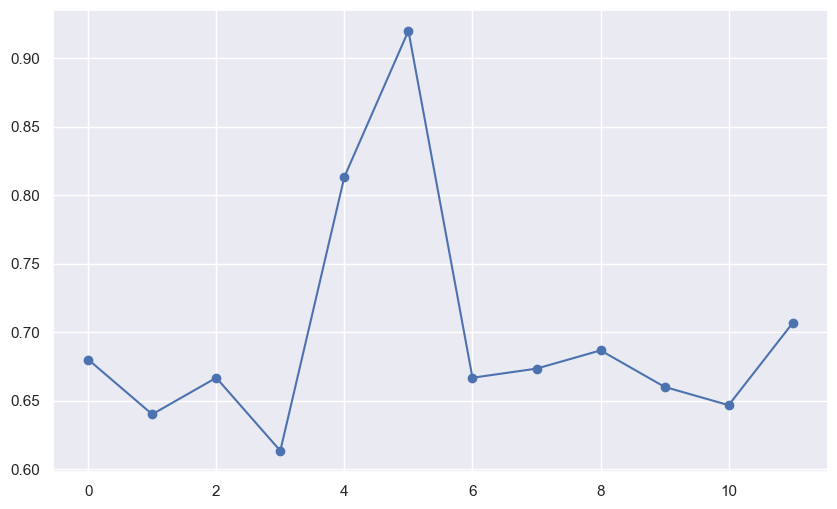

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')